# Carga

In [11]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import layers, callbacks

In [59]:
# Vuelos
fli = pd.read_csv('/content/Filghts TEC_Valid.csv')

# DB - Limpieza de vuelos

In [60]:
# Convertir a fecha las salidas y llegadas
fli['STD'] = pd.to_datetime(fli['STD'])
fli['STA'] = pd.to_datetime(fli['STA'])

## Predict - 2024
Base de datos del 2024 (año a predecir)

In [ ]:
# Filtro de solo el 2024
fli_pred = fli[(fli['STD'].dt.year == 2024)]
# Columnas no significantes al modelo
fli.drop(['Flight_ID', 'Aeronave','Destination_Type', 'Origin_Type','Bookings'], axis = 1, inplace = True)

In [ ]:
# ¿El vuelo es en fin de semana? 1. Si, 0. No
fli_pred['Weekend'] = np.where(fli_pred['STD'].dt.weekday >= 4, 1,0)
# Mes (en número) del vuelo
fli_pred['Month'] = fli_pred['STD'].dt.month.astype(str)
# Hora redondeada del vuelo
fli_pred['Hour'] = fli_pred['STD'].dt.hour.astype(str)
# Duración (float) del vuelo en horas
fli_pred['Duration'] = np.round((fli_pred['STA'] - fli_pred['STD']).dt.total_seconds()/3600,2)
# Columnas no útiles al modelo
fli_pred.drop(['STD','STA'], axis = 1, inplace = True)
# Reordenamiento de columnas
fli_pred = fli_pred[['DepartureStation', 'ArrivalStation', 'Capacity', 'Weekend', 'Month','Hour', 'Duration']]

In [ ]:
# Base de datos de variables independientes para predecir 2024
fli_pred.to_csv('fli_pred2024.csv', index = False)

## Train and test 2023
Base de datos del 2023, usada para el entrenamiento y prueba de los modelos.

In [61]:
# Eliminar los registros que sean del 2024 y Aeronaves nulas
fli = fli[(fli['STD'].dt.year != 2024) & ~(fli['Aeronave'].isnull())]
# Manejo de sobreventa
fli.loc[fli['Passengers'] > fli['Capacity'], 'Passengers'] = fli['Capacity']
# Columnas no útiles al modelo
fli.drop(['Flight_ID', 'Aeronave','Destination_Type', 'Origin_Type','Bookings'], axis = 1, inplace = True)

<ipython-input-61-c0f06ac6c8d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fli.drop(['Flight_ID', 'Aeronave','Destination_Type', 'Origin_Type','Bookings'], axis = 1, inplace = True)


In [62]:
# ¿El vuelo es en fin de semana? 1. Si, 0. No
fli['Weekend'] = np.where(fli['STD'].dt.weekday >= 4, 1,0)
# Mes (en número) del vuelo
fli['Month'] = fli['STD'].dt.month.astype(str)
# Hora redondeada del vuelo
fli['Hour'] = fli['STD'].dt.hour.astype(str)
# Duración (float) del vuelo en horas
fli['Duration'] = np.round((fli['STA'] - fli['STD']).dt.total_seconds()/3600,2)
# Columnas no útiles al modelo
fli.drop(['STD','STA'], axis = 1, inplace = True)
# Reordenamiento de columnas
fli = fli[['DepartureStation', 'ArrivalStation', 'Capacity', 'Weekend', 'Month','Hour', 'Duration','Passengers']]
# Manejo de outliers - Vuelos mayores a 20hrs
fli = fli[fli.Duration < 20]

In [ ]:
# Base de datos
fli.to_csv('Flights_Limpia.csv', index = False)

### Separación por capacidad de pasajeros

Se observó una clara distinción en el histograma de pasajeros por capacidad de pasajeros (se encuentra en el documento de Análisis Exploratorio adjuntado), donde se revela una distinción (punto máximo) entre los aviones con una capacidad hasta 186 pasajeros y el resto. Por lo que se decidió realizar el modelo de acuerdo a los dos comportamientos encontrados.

In [106]:
# Vuelos de aviones hasta con una capacidad de 186
fli_cap1 = fli[fli['Capacity'] <= 186]

In [86]:
# Vuelos de aviones con una capacidad mayor a 186
fli_cap2 = fli[~(fli['Capacity'] <= 186)]

### Manejo outliers

#### Capacidad 1

Se calcula el número de pasajeros que están a 3 desviaciones estándar del cuartil del 50%, esto da un valor de a partir de 94 pasajeros. Con esto se representan el 99% de los datos.

In [ ]:
fli_cap1.describe()['Passengers']

count    63753.000000
mean       163.692109
std         26.482421
min          1.000000
25%        151.000000
50%        174.000000
75%        185.000000
max        186.000000
Name: Passengers, dtype: float64

In [ ]:
# Outliers a partir del:
174-(26.482421*3)

94.55273700000001

In [107]:
fli_cap1 = fli_cap1[fli_cap1['Passengers'] >= 94]

In [ ]:
# Base de datos
fli_cap1.to_csv('Flights_Cap1.csv', index = False)

#### Capacidad 2

Se calcula el número de pasajeros que están a 3 desviaciones estándar del cuartil del 50%, esto da un valor de a partir de 108 pasajeros. Con esto se representan el 99% de los datos.

In [87]:
fli_cap2.describe()['Passengers']

count    57971.000000
mean       202.540115
std         34.885208
min          1.000000
25%        183.000000
50%        213.000000
75%        229.000000
max        240.000000
Name: Passengers, dtype: float64

In [66]:
# Outliers a partir del:
213-(34.885208*3)

108.34437600000001

In [88]:
fli_cap2 = fli_cap2[fli_cap2['Passengers'] >= 108]

In [98]:
# Base de datos
fli_cap2.to_csv('Flights_Cap2.csv', index = False)

# Modelo Capacidad 1

## RNN

### Funciones y tratamiento

In [130]:
# Función para evaluar los modelos
def evaluate(model, X_test_preprocessed, y_test, y_pred, history):
  # Errores y métricas
  mse = mean_squared_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  # Despliegue
  print("Mean Squared Error:", mse)
  print("Mean Absolute Error:", mae)
  print("R^2 Score:", r2)

  # Visualizar loss durante training y validation
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.legend()
  plt.show()

In [13]:
# Dividir en variables dependientes y dependiente
X = fli_cap1.drop(columns=['Passengers'])
y = fli_cap1['Passengers']

# Dividir los datos en training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variables numéricas - Escalamiento
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
numeric_preprocessor = StandardScaler()
X_train_numeric = numeric_preprocessor.fit_transform(X_train[numeric_features])
X_test_numeric = numeric_preprocessor.transform(X_test[numeric_features])

# Variables categóricas - OneHotEncoder
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_preprocessor = OneHotEncoder()
X_train_categorical = categorical_preprocessor.fit_transform(X_train[categorical_features])
X_test_categorical = categorical_preprocessor.transform(X_test[categorical_features])

# Juntar las variables numéricas y categóricas
X_train_preprocessed = np.hstack((X_train_numeric, X_train_categorical.toarray()))
X_test_preprocessed = np.hstack((X_test_numeric, X_test_categorical.toarray()))

### Modelo 1

Modelo 1 de RN para la predicción. Se obtuvieron los siguientes errores y métricas. El menos adecuado es R^2 ya que solo se ajusta al 22% de los datos. Aparte se observa un overfitting a partir de la epoca 13 aproximadamente.

Epoch 1/100
1245/1245 [==============================] - 5s 3ms/step - loss: 2099.3267 - val_loss: 415.6125
Epoch 2/100
1245/1245 [==============================] - 3s 3ms/step - loss: 615.3976 - val_loss: 414.9177
Epoch 3/100
1245/1245 [==============================] - 3s 2ms/step - loss: 591.6732 - val_loss: 405.9850
Epoch 4/100
1245/1245 [==============================] - 4s 3ms/step - loss: 568.6347 - val_loss: 410.4605
Epoch 5/100
1245/1245 [==============================] - 3s 3ms/step - loss: 558.3438 - val_loss: 392.6878
Epoch 6/100
1245/1245 [==============================] - 3s 2ms/step - loss: 550.5557 - val_loss: 415.9115
Epoch 7/100
1245/1245 [==============================] - 3s 3ms/step - loss: 539.8611 - val_loss: 440.1619
Epoch 8/100
1245/1245 [==============================] - 4s 3ms/step - loss: 529.0881 - val_loss: 387.3076
Epoch 9/100
1245/1245 [==============================] - 3s 3ms/step - loss: 511.7483 - val_loss: 369.0894
Epoch 10/100
1245/1245 [============

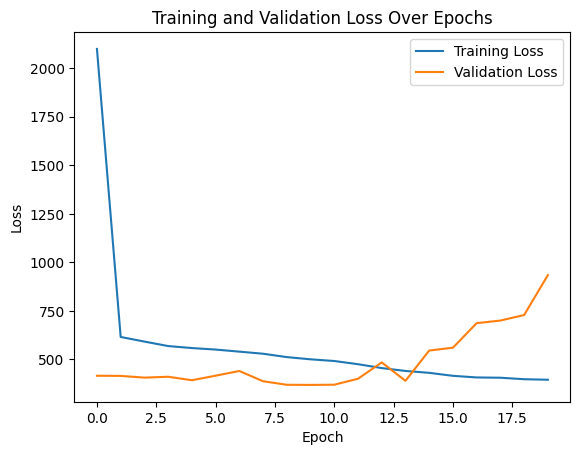

In [14]:
# Construir RN
model = tf.keras.Sequential([
    # capas
    layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Capa de salida para la predicción
])

# Compilar modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Definir callbacks para parar el modelo
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento
history = model.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predicción
y_pred = model.predict(X_test_preprocessed)

# Evaluación
evaluate(model, X_test_preprocessed, y_test, y_pred, history)

### Modelo 2

Debido al overfitting presentado en el modelo 1, se decidió disminuir el número de epochs, permitiendo evitar el overfitting. Con esto, se obtuvo que el modelo emperó y siguió haciendo overfitting, así que se decidió mover con otra estructura.

Epoch 1/13
1245/1245 [==============================] - 5s 3ms/step - loss: 2076.3687 - val_loss: 412.6308
Epoch 2/13
1245/1245 [==============================] - 4s 3ms/step - loss: 622.4291 - val_loss: 404.0667
Epoch 3/13
1245/1245 [==============================] - 6s 5ms/step - loss: 596.7797 - val_loss: 392.1256
Epoch 4/13
1245/1245 [==============================] - 5s 4ms/step - loss: 588.2684 - val_loss: 428.8510
Epoch 5/13
1245/1245 [==============================] - 7s 6ms/step - loss: 573.5582 - val_loss: 419.4714
Epoch 6/13
1245/1245 [==============================] - 5s 4ms/step - loss: 556.1967 - val_loss: 406.6468
Epoch 7/13
1245/1245 [==============================] - 3s 3ms/step - loss: 542.6074 - val_loss: 375.1956
Epoch 8/13
1245/1245 [==============================] - 4s 3ms/step - loss: 530.1087 - val_loss: 383.4452
Epoch 9/13
1245/1245 [==============================] - 7s 5ms/step - loss: 521.4133 - val_loss: 422.7234
Epoch 10/13
1245/1245 [======================

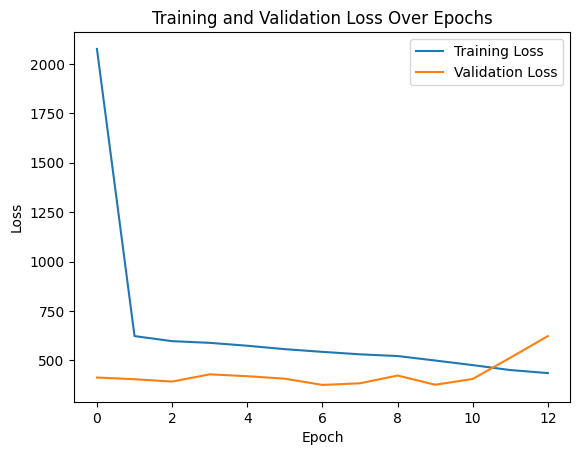

In [174]:
# Construir RN
model = tf.keras.Sequential([
    # capas
    layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Capa de salida para la predicción
])

# Compilar modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Definir callbacks para parar el modelo
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento
history = model.fit(X_train_preprocessed, y_train, epochs=13, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Predicción
y_pred = model.predict(X_test_preprocessed)

# Evaluación
evaluate(model, X_test_preprocessed, y_test, y_pred, history)

### Modelo 3 - Final
Modelo 2 de RN para la predicción. Se cambió el valor de dropout y learning_rate.

Se obtuvieron errores de MSE y MAE similares al anterior, con la diferencia que se obtuvo un mejor R^2 que se ajusta al 35% de los datos. Por lo que se decidió trabajar con este

Epoch 1/100
1245/1245 [==============================] - 12s 8ms/step - loss: 2252.8311 - mean_absolute_error: 31.4570 - val_loss: 408.5018 - val_mean_absolute_error: 15.9479
Epoch 2/100
1245/1245 [==============================] - 4s 3ms/step - loss: 745.4869 - mean_absolute_error: 21.8524 - val_loss: 404.1411 - val_mean_absolute_error: 16.1907
Epoch 3/100
1245/1245 [==============================] - 4s 3ms/step - loss: 716.3600 - mean_absolute_error: 21.4116 - val_loss: 405.4598 - val_mean_absolute_error: 16.4176
Epoch 4/100
1245/1245 [==============================] - 4s 4ms/step - loss: 696.2352 - mean_absolute_error: 21.1202 - val_loss: 411.6821 - val_mean_absolute_error: 15.0914
Epoch 5/100
1245/1245 [==============================] - 4s 3ms/step - loss: 676.1506 - mean_absolute_error: 20.7612 - val_loss: 396.6584 - val_mean_absolute_error: 15.0604
Epoch 6/100
1245/1245 [==============================] - 4s 3ms/step - loss: 650.6574 - mean_absolute_error: 20.3861 - val_loss: 382.

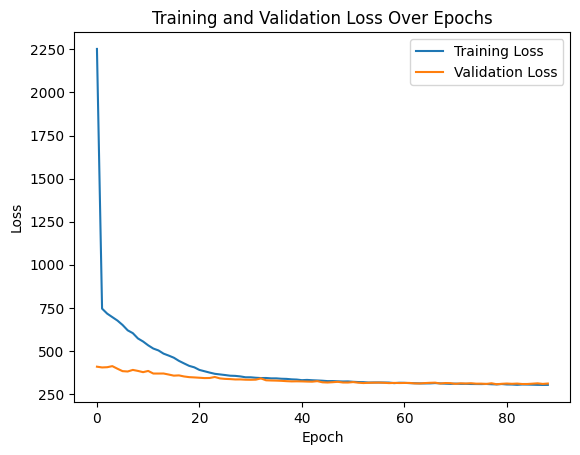

In [ ]:
# Arqui del modelo 2 de RN
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Capa de salida para la predicción
])

# Compilar modelo con regularización L2 y tasa de aprendizaje adaptativa
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# Definir callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenamiento
history = model.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping])

# Predicción
y_pred = model.predict(X_test_preprocessed)

# Evaluación
evaluate(model, X_test_preprocessed, y_test, y_pred, history)

In [17]:
# Guardar modelo
keras.saving.save_model(model, 'Modelo_Cap1', overwrite=True)

## Predicciones

In [12]:
# Registros del 2024 a predecir
fli_pred = pd.read_csv('fli_pred2024.csv')

In [13]:
# Variables numéricas y categóricas
numeric_features = fli_pred.select_dtypes(include=['float64', 'int64']).columns
categorical_features = fli_pred.select_dtypes(include=['object']).columns

# Numéricas - escalar
numeric_preprocessor = StandardScaler()
X_numeric = numeric_preprocessor.fit_transform(fli_pred[numeric_features])

# Categóricas - Codificación
categorical_preprocessor = OneHotEncoder()
X_categorical = categorical_preprocessor.fit_transform(fli_pred[categorical_features])

# Concatenar numéricas y categóricas
X_preprocessed = np.hstack((X_numeric, X_categorical.toarray()))

# Cargar el modelo final para predicciones
loaded_model = keras.saving.load_model('Modelo_Cap1')

# Predicción
y_pred_2024 = loaded_model.predict(X_preprocessed)

3807/3807 [==============================] - 11s 3ms/step


In [163]:
# Formato de predicción
y_pred_2024 = np.round(y_pred_2024)
fli_pred['Passengers'] = pd.Series([x[0] for x in y_pred_2024])
# Predicción de sobrecarga
fli_pred.loc[fli_pred['Passengers'] > fli_pred['Capacity'], 'Passengers'] = fli_pred['Capacity']
# Solo con la capacidad correspondida al modelo
fli_pred = fli_pred[fli_pred['Capacity'] <= 186]

In [164]:
# Tabla 2024
fli_pred.to_csv('Pred_2024_Cap1.csv', index = False)

# Modelo Capacidad 2

In [143]:
# Dataset para entrenar de capacidad 2
fli_cap2 = pd.read_csv('/content/Flights_Cap2.csv')

In [144]:
# Variables independientes y dependiente
X = fli_cap2.drop(columns=['Passengers'])
y = fli_cap2['Passengers']

# Training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Numéricas
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
numeric_preprocessor = StandardScaler()
X_train_numeric = numeric_preprocessor.fit_transform(X_train[numeric_features])
X_test_numeric = numeric_preprocessor.transform(X_test[numeric_features])

# Categóricas
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_preprocessor = OneHotEncoder()
X_train_categorical = categorical_preprocessor.fit_transform(X_train[categorical_features])
X_test_categorical = categorical_preprocessor.transform(X_test[categorical_features])

# Concatenar numéricas y categóricas
X_train_preprocessed = np.hstack((X_train_numeric, X_train_categorical.toarray()))
X_test_preprocessed = np.hstack((X_test_numeric, X_test_categorical.toarray()))

## Modelo 1

Se creó el primer modelo igual que con la capacidad 1. Esto resultó mucho mejor que con la capacidad anterior, obteniendo un ajuste del 35% y valores similares con el Modelo Final de capacidad 1. Por lo que se decidió continuar con este modelo.

Epoch 1/100
1245/1245 [==============================] - 7s 4ms/step - loss: 2100.0005 - val_loss: 415.6715
Epoch 2/100
1245/1245 [==============================] - 3s 3ms/step - loss: 612.0342 - val_loss: 399.4113
Epoch 3/100
1245/1245 [==============================] - 5s 4ms/step - loss: 599.8564 - val_loss: 408.2271
Epoch 4/100
1245/1245 [==============================] - 3s 2ms/step - loss: 578.9922 - val_loss: 384.1934
Epoch 5/100
1245/1245 [==============================] - 4s 3ms/step - loss: 569.7459 - val_loss: 383.0527
Epoch 6/100
1245/1245 [==============================] - 4s 3ms/step - loss: 551.1155 - val_loss: 385.2843
Epoch 7/100
1245/1245 [==============================] - 6s 5ms/step - loss: 539.4279 - val_loss: 382.3769
Epoch 8/100
1245/1245 [==============================] - 6s 4ms/step - loss: 529.9663 - val_loss: 376.2371
Epoch 9/100
1245/1245 [==============================] - 5s 4ms/step - loss: 521.8073 - val_loss: 407.0257
Epoch 10/100
1245/1245 [============

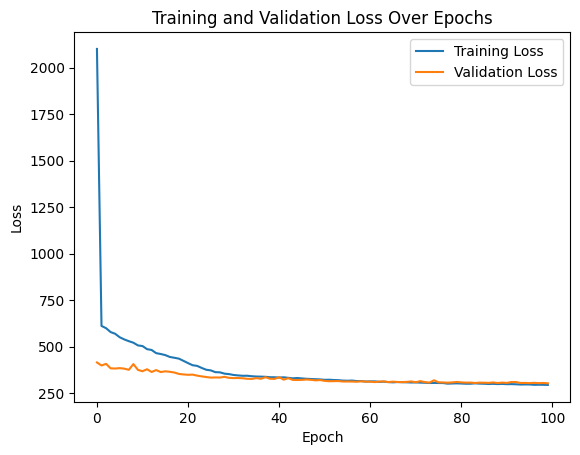

In [145]:
# Construir el modelo
model = tf.keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_preprocessed.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Capa de salida para la predicción
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Definir callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model.fit(X_train_preprocessed, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

y_pred = model.predict(X_test_preprocessed)

evaluate(model, X_test_preprocessed, y_test, y_pred, history)

In [147]:
# gaurdar modelo
keras.saving.save_model(model, 'Modelo_Cap2', overwrite=True)

## Predicciones

In [150]:
# DB del 2024
fli_pred = pd.read_csv('fli_pred2024.csv')

In [151]:
# Variables numéricas y categóricas
numeric_features = fli_pred.select_dtypes(include=['float64', 'int64']).columns
categorical_features = fli_pred.select_dtypes(include=['object']).columns

# Numéricas
numeric_preprocessor = StandardScaler()
X_numeric = numeric_preprocessor.fit_transform(fli_pred[numeric_features])

# Categóricas
categorical_preprocessor = OneHotEncoder()
X_categorical = categorical_preprocessor.fit_transform(fli_pred[categorical_features])

# Concatenar
X_preprocessed = np.hstack((X_numeric, X_categorical.toarray()))

# Cargar modelo
loaded_model = keras.saving.load_model('Modelo_Cap2')

# Predicción
y_pred_2024 = loaded_model.predict(X_preprocessed)

3807/3807 [==============================] - 9s 2ms/step


In [153]:
# Formato predicción
y_pred_2024 = np.round(y_pred_2024)
fli_pred['Passengers'] = pd.Series([x[0] for x in y_pred_2024])
# Sobreventa de predicción
fli_pred.loc[fli_pred['Passengers'] > fli_pred['Capacity'], 'Passengers'] = fli_pred['Capacity']
# Capacidad correspondiente
fli_pred = fli_pred[fli_pred['Capacity'] > 186]

In [160]:
# Tabla con predicciones 2024
fli_pred.to_csv('Pred_2024_Cap2.csv', index = False)